# Prepare SROIE 2019 NER Dataset

- Directory `0325updated.task1train\(626p\)` consists of receipt images and text files wit corresponding OCR text information
- Directory `0325updated.task2train\(626p\)` consists of receipt images and key-value information to be extrcted

In [1]:
import os
import sys
import json
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import random
from IPython import display
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline

In [2]:
# Get list of all image files with relative path
img_files = os.listdir("0325updated.task1train(626p)")
img_files = list(map(lambda file: "0325updated.task1train(626p)/" + file, img_files))
img_files = [file for file in img_files if file.endswith(".jpg")]
img_files = {file.split("/")[-1].split(".")[0] : file for file in img_files}

In [18]:
def get_text_file_dicts(directory):
    """
    List all the files in the directory and filter .txt files
    
    return:
        dict : {file_name_without_extension : relative_path}
    """
    res = defaultdict(None)
    all_files = os.listdir(directory)
    text_files = [file for file in all_files if file.endswith(".txt")]
    text_files = list(map(lambda file: directory + "/" + file, text_files))
    for file in text_files:
        key = file.split("/")[-1].split(".")[0] # extract file name
        res[key]= file
            
    return res

In [19]:
def extract(ocr_text_file, ie_text_file):
    """
    Match the OCR text with key value pair from infromation extraction task
    """
    
    if ocr_text_file is None or ie_text_file is None:
        return None
    
    if not os.path.exists(ocr_text_file) or not os.path.exists(ie_text_file):
        return None
    
    ocr_text_file_lines = open(ocr_text_file).readlines()
    # extract the text from the line
    ocr_text_file_lines = list(map(lambda line: " ".join(line.split(",")[8:]).strip(), ocr_text_file_lines))
    # add default tag O to each line
    base_ner_data = {line : 'O' for line in ocr_text_file_lines}
    
    
    ie_text_file_lines = open(ie_text_file).readlines()
    ie_text_file_lines = "".join(ie_text_file_lines)
    # read the data as dict
    ie_data = json.loads(ie_text_file_lines)
    
    # print(ie_data)
    res = {}
    
    for ocr_text, v in base_ner_data.items():
        for tag, ner_text in ie_data.items():
            ner_text = ner_text.replace(",", "")
            
            # omit empty string lines and length less than 2
            if ocr_text != '' and len(ocr_text) > 2 and (ocr_text in ner_text or ner_text in ocr_text):
                base_ner_data[ocr_text] = tag
             
            # For those lines which have multiple tokens
            num_matches = 0 
            for token in ocr_text.split(" "):
                if token != '' and token in ner_text:
                    num_matches += 1
                    
            # make sure we find atleast 2 matches per line to tag that line with respective tag        
            if num_matches > 2:
                base_ner_data[ocr_text] = tag
                    
    return base_ner_data
    

In [20]:
def tagged_data_to_conll(data: dict):
    """
    Given dict of lines and tags, convert it into CoNLL format
    """
    if data is None:
        return None
    
    res = []
    
    for text, tag in data.items():
        for token in text.split(" "):
            res.append((token, tag))
    return res

In [21]:
tagged_data_to_conll({"sentence 1 about ot get tagged" : "TAG1", "2021-10-24": "date"})

[('sentence', 'TAG1'),
 ('1', 'TAG1'),
 ('about', 'TAG1'),
 ('ot', 'TAG1'),
 ('get', 'TAG1'),
 ('tagged', 'TAG1'),
 ('2021-10-24', 'date')]

In [22]:
train_ocr_text_files_dict = get_text_file_dicts("0325updated.task1train(626p)")
train_ie_text_files_dict = get_text_file_dicts("0325updated.task2train(626p)")
files = sorted(train_ocr_text_files_dict.keys())

## Test 

0325updated.task1train(626p)/X51008164997.txt
[('ONE', 'company'), ('ONE', 'company'), ('THREE', 'company'), ('SEAFOOD', 'company'), ('RESTAURANT', 'company'), ('SDN', 'company'), ('BHD', 'company'), ('(1120908-M)', 'O'), ('NO.1', 'address'), ('', 'address'), ('TAMAN', 'address'), ('SRI', 'address'), ('DENGKIL', 'address'), ('', 'address'), ('JALAN', 'address'), ('AIR', 'address'), ('HITAM', 'address'), ('43800', 'address'), ('DENGKIL', 'address'), ('', 'address'), ('SELANGOR.', 'address'), ('(GST', 'O'), ('REG.', 'O'), ('NO', 'O'), (':', 'O'), ('000670224384)', 'O'), ('TAX', 'O'), ('INVOICE', 'O'), ('TABLE', 'O'), ('37', 'O'), ('BILL#:V001-540417', 'O'), ('ORDER#:', 'O'), ('140523', 'O'), ('DATE', 'O'), (':', 'date'), ('15-06-2018', 'date'), ('11:35:35', 'date'), ('CASHIER:', 'O'), ('113', 'O'), ('CASHIER', 'O'), ('PAX(S):', 'O'), ('0', 'O'), ('QTY', 'O'), ('DESCRIPTION', 'O'), ('TOTAL', 'O'), ('TAX', 'O'), ('1', 'O'), ('D', 'O'), ('120.00', 'O'), ('SR', 'O'), ('CAT', 'O'), ('FISH', '

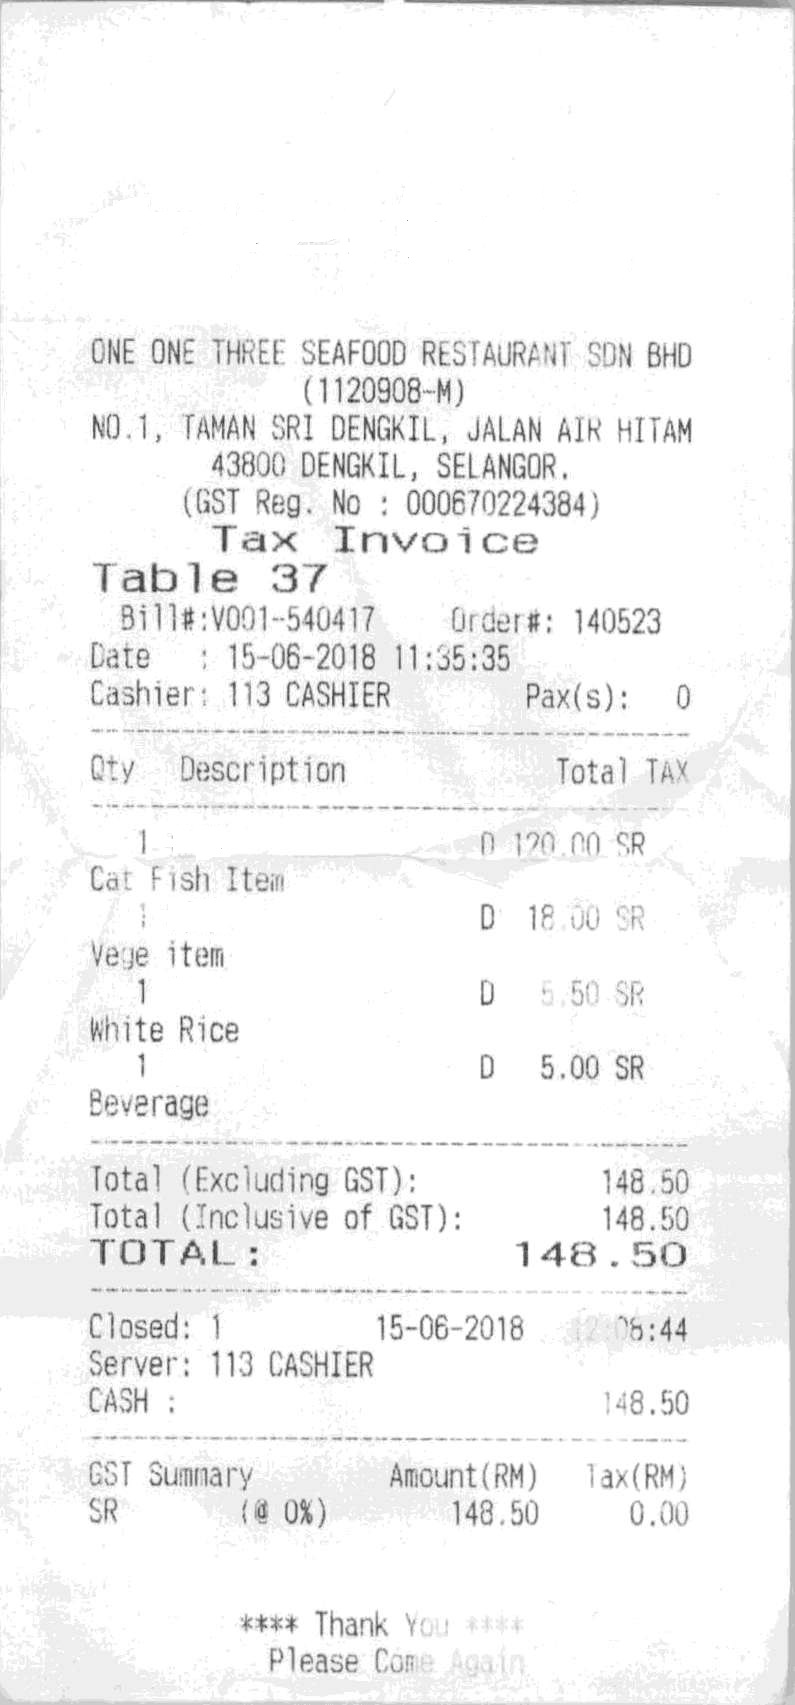

In [28]:
key = random.choice(list(train_ocr_text_files_dict.keys()))
ocr_text_file = train_ocr_text_files_dict.get(key)
ie_text_file = train_ie_text_files_dict.get(key)
print(ocr_text_file)
data = extract(ocr_text_file, ie_text_file)
print(tagged_data_to_conll(data))

img_file = img_files.get(key.replace(".txt", ".jpg"))
display.Image(img_file)

In [29]:
len(train_ocr_text_files_dict.keys()), len(train_ie_text_files_dict.keys())

(835, 876)

In [32]:
def create_data_file(file_path, files):
    res = []
    for file in tqdm(files):
        ocr_text_file = train_ocr_text_files_dict.get(file)
        ie_text_file = train_ie_text_files_dict.get(file)
        data = tagged_data_to_conll(extract(ocr_text_file, ie_text_file))
        if data:
            res.append(data)

    with open(file_path, "w") as file:
        for lines in res:
            for line in lines:
                file.write(" ".join(list(line)))
                file.write("\n")
            file.write("\n")

## Prepare train dataset

In [33]:
train_files = files[:700]
create_data_file(file_path="version1/train.txt", files=train_files)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:02<00:00, 287.75it/s]


## Prepare valid dataset

In [34]:
valid_files = files[700:750]
create_data_file(file_path="version1/valid.txt", files=valid_files)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.33it/s]


## Prepare test dataset

In [35]:
test_files = files[750:]
create_data_file(file_path="version1/test.txt", files=test_files)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 228.23it/s]
